# Vocabulary Tree for Image Descriptors with Binary Descriptors

## Introduction
This notebook describes how to implement a scalable image search with vocabulary tree.

The work is largerly based on the article: **Scalable Recognition with a vocabulary tree**, David Nister and Henrik Stewenius

link to paper: http://www-inst.eecs.berkeley.edu/~cs294-6/fa06/papers/nister_stewenius_cvpr2006.pdf

However some innovations were applied:
* Use of **ORB** as image descriptors instead of patented **SIFT** described in the article 
* Use of **hamming distance** as distance measure among descritors 
* Use of **bit-wise average** as opposed to numerical average (since ORB is binary and not numerical as SIFT)
* **Flexible clustering algorithm** that makes use of custom distance measure and average as above to work with both binary or numerical image descriptors 

Results seem to indicate good results with the approach cited above from queries in a small dataset.

So far, this notebook provides a relatively simple code in python that implements this algorithm


## Solution 
The algorithm is composed by several steps expressed as functions in the next subsections.
* tree data structure 
* flexible clustering
* tree assembly 
* tree weight update
* tree visit
* score calculation
* image database visit vector
* helper functions to read image database and query image descriptors

The following section describes a simple test.

In [21]:
# pip install opencv-python
# pip install opencv-contrib-python
import cv2 
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Node Data Structure

In [2]:
class Node:
    _nodes = []       # list of all created nodes
    _total_images = 0 # total number of images
    
    def __init__(self, root=False):
        self._children = {}  # dictionary key(img descriptor) -> value
        self._images = set() # set of image ids
        if not root:
            self._index = len(Node._nodes)
            Node._nodes.append(self) # append node to global list of nodes
            
    @property
    def children(self):
        return self._children
    @children.setter
    def children(self, children):
        self._children = children
        
    @property
    def images(self):
        return self._images
    @images.setter
    def images(self, images):
        self._images = images
        
    @property
    def weight(self):
        if len(self.images) > 0:
            return np.log(Node._total_images/len(self._images))
        else:
            return 0
        
    @property
    def index(self):
        return self._index
    
    @staticmethod
    def set_total_images(total_images):
        Node._total_images = total_images
        
    @staticmethod
    def nodes():
        return Node._nodes
    
    @staticmethod
    def init():
        Node._nodes = []


        
def tree_traversal(node):
    print('node.images='+str(node.images) + ' node.children='+str(len(node.children)))
    for child_id in node.children:
        print('node.descriptor='+str(hash(child_id)))
        tree_traversal(node.children[child_id])

### Configurable Clustering Algorithms Based on K-Means 

In [3]:
# clustering image descriptors
def clustering(data, k, dissimilarity, average, stop_criteria=0.1, attempts=3):
    centroids = _choose_initial_centroids(data, k)
    centroid_labels = None
    diff = 100000
    
    while diff > stop_criteria:
        centroid_labels = _find_nearest_centroid(data, centroids, dissimilarity)
        new_centroids = _calculate_new_centroids(data, centroid_labels, k, average)
        diff = _average_centroids_move(centroids, new_centroids)
        centroids = new_centroids
    
    return centroids, centroid_labels  




def _choose_initial_centroids(data, k):
    centroid_idxs = np.random.randint(data.shape[0], size=k)
    return data[centroid_idxs]



def _find_nearest_centroid(data, centroids, dissimilarity):
    centroid_labels = {}
    for idx in range(len(centroids)):
        centroid_labels[idx] = []
        
    for item_idx, item in enumerate(data):
        min_dist = None
        centroid_id = None
        for centroid_idx, c in enumerate(centroids):  
            distance = dissimilarity(item, c)
            if min_dist == None or distance < min_dist:
                min_dist = distance
                centroid_id = centroid_idx
        centroid_labels[centroid_id].append(item_idx)
    
    return centroid_labels



def _calculate_new_centroids(data, centroid_labels, k, average):
    centroids = []
    
    for centroid_idx in centroid_labels:
        centroid_data = data[centroid_labels[centroid_idx]]
        centroids.append(average(centroid_data))
    
    return np.array(centroids)



def _average_centroids_move(centroids, new_centroids):
    return np.sum(np.abs(centroids - new_centroids))

### Assembly Image Descriptor Tree

In [4]:
def assembly_tree(descriptors, k, dissimilarity, average, level):
    level -= 1
    if level < 0:
        return {}

    centroids, centroid_labels = clustering(descriptors, k, dissimilarity, average)
    children = {}
    for centroid_id, centroid in enumerate(centroids):
        if len(centroid_labels[centroid_id]) > 0:
            node = Node()
            centroid_descriptors = np.array(descriptors[centroid_labels[centroid_id]])
            node.children = assembly_tree(centroid_descriptors, k, dissimilarity, average, level)
            children[centroid.tobytes()] = node
            
    return children

### Updating Tree Weights

In [5]:
def update_weights(node, img_idx, arr_descriptors, dissimilarity):
    for descriptor in arr_descriptors:
        _update_weights_with_descriptor(node, img_idx, descriptor, dissimilarity)

# descriptor - query descriptor
# arr_descriptors - array of descriptors
# return: descritor in arr_descriptors close to descriptor
def _nearest_descriptor(descriptor, arr_descriptors, dissimilarity):
    min_dist = None
    min_descriptor = None
    for descriptor_item in arr_descriptors:
        distance = dissimilarity(descriptor, descriptor_item)
        if min_dist == None or distance < min_dist:
            min_dist = distance
            min_descriptor = descriptor_item
    return min_descriptor


def _convert_to_img_descriptor(descriptor_bytes):
    return np.frombuffer(descriptor_bytes, dtype=np.uint8)


def _update_weights_with_descriptor(node, img_idx, descriptor, dissimilarity):
    if len(node.children) > 0:
        arr_descriptors = list(map(_convert_to_img_descriptor, node.children.keys()))
        nearest_descriptor = _nearest_descriptor(descriptor, arr_descriptors, dissimilarity)
        child_node = node.children[nearest_descriptor.tobytes()]
        child_node.images.add(img_idx)
        _update_weights_with_descriptor(child_node, img_idx, descriptor, dissimilarity)


### Node Visiting

In [6]:
def visit_tree(root, descriptors, dissimilarity, with_weight=False):
    visit_path = np.zeros(len(Node.nodes()))
    for descriptor in descriptors:
        _descriptor_visit_tree(root, descriptor, dissimilarity, visit_path)
        
    if with_weight:
        for idx, visit in enumerate(visit_path):
            visit_path[idx] *= Node.nodes()[idx].weight

    return visit_path


def _descriptor_visit_tree(node, descriptor, dissimilarity, visit_path):
    if node.children == {}:
        return visit_path
    
    arr_descriptors = list(map(_convert_to_img_descriptor, node.children.keys()))
    nearest_descriptor = _nearest_descriptor(descriptor, arr_descriptors, dissimilarity)
    child_node = node.children[nearest_descriptor.tobytes()]
    visit_path[child_node.index] += 1
    
    return _descriptor_visit_tree(child_node, descriptor, dissimilarity, visit_path)

### Score Calculation

In [7]:
# query_vector = vector of visits multiplied by weights from query image descriptors
# dbimg_vector = vector of visits multiplied by weights from database image descriptors
def score_calculation(query_vector, dbimg_vector):
    norm_query_vector = query_vector / (np.sqrt(np.sum(np.power(query_vector, 2))))
    norm_dbimg_vector = dbimg_vector / (np.sqrt(np.sum(np.power(query_vector, 2))))
    diff = np.abs(norm_query_vector - norm_dbimg_vector)
    return np.sqrt(np.sum(np.power(diff, 2)))
    

### Create Matrix for Image Database Visit Vector

In [8]:
# root:            tree root node
#
# cvmat_images:    list of B&W cvMat images read from cv2.imread
#
# dissimilarity:   dissimilarity function to compare 2 image descriptors
#
# with_weight:     (T/F) should multiply with node weight or just number of visits per node
#
# descr_extractor: image descriptor extractor (as default ORB)
#
def dbimg_visit_tree(root, cvmat_images, dissimilarity, with_weight=True, descr_extractor=cv2.ORB_create()):
    # list of visit per database image
    dbimg_vectors = []
    for img in cvmat_images:
        keypoints, descriptors = descr_extractor.detectAndCompute(img, None)
        
        # create visit vector from image and add to list
        img_vector = visit_tree(root, descriptors, dissimilarity, with_weight)
        dbimg_vectors.append(img_vector)
        
    return np.array(dbimg_vectors)

### Helper Function to Read Image Files

In [9]:
def read_images(filenames, black_white=True):
    images = []
    for filename in filenames:
        images.append(read_image(filename, black_white))
    
    return np.array(images)



def read_image(filename, black_white=True):
    if black_white:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(filaneme, cv2.IMREAD_COLOR)
        
    return image



def image_descriptors_map(images, descr_extractor):
    img_descriptors = {}
    
    for idx, image in enumerate(images):
        # extract image descriptors
        keypoints, descriptors = descr_extractor.detectAndCompute(image, None)
        img_descriptors[idx] = []
        for descriptor in descriptors:
            img_descriptors[idx].append(descriptor)
        img_descriptors[idx] = np.array(img_descriptors[idx], dtype=np.uint8)
            
    return img_descriptors



def image_descriptors(image_descriptors_map):
    img_descriptors = []
    
    for img_key in image_descriptors_map:
        img_descriptors.extend(image_descriptors_map[img_key])
        
    return np.array(img_descriptors, dtype=np.uint8)

def image_descriptors_from_file(filename, descr_extractor):
    img = read_image(filename)
    keypoints, descriptors = descr_extractor.detectAndCompute(img, None)
    return descriptors

## Tests

In [10]:
filenames = list([ './imgdb/' + filename for filename in os.listdir('./imgdb/') ])
print('database filenames')
print('==================')
print(str(filenames))
print()

query_files = list([ './query/' + filename for filename in os.listdir('./query') ])
print('query filenames')
print('===============')
print(str(query_files))

database filenames
['./imgdb/shoes-2.png', './imgdb/fruits-1.jpg', './imgdb/fruits-2.jpg', './imgdb/shoes-1.jpg', './imgdb/shoes-3.jpg', './imgdb/helicopter-1.jpg', './imgdb/book-1.jpg', './imgdb/fruits-4.jpg', './imgdb/helicopter-2.jpg', './imgdb/fruit3-3.jpg', './imgdb/shoes-4.png', './imgdb/shoes-5.jpg', './imgdb/helicopter-3.jpg', './imgdb/helicopter-4.jpg']

query filenames
['./query/shoes.png', './query/helicopter.jpg', './query/fruits-4.jpg', './query/book.jpg', './query/fruits.jpg']


### Test1: ORB / hamming distance / bit-wise average

Next block below defines the parameters for this experiments.
* ORB as image descriptor
* hamming as distance measure
* bit-wise as average strategy
* 6 clusters (also means that the vocabulary tree node will have 6 children
* 5 max vertical levels for the tree

In [11]:
# pre-condition: uint8 arrays - hamming distance
def orb_dissimilarity(elem1, elem2):
    return cv2.norm(elem1, elem2, cv2.NORM_HAMMING) 

# pre-condition: uint8 arrays - bit-wise average
def orb_average(data):
    bit_array = np.unpackbits(data, axis=1)
    avg_array = np.mean(bit_array, axis=0)
    avg_array = np.round(avg_array).astype(np.uint8)
    avg_data = np.packbits(avg_array)
    return avg_data

# Set number of images
Node.set_total_images(len(filenames))

# Set image descriptor extractor
orb_extractor = cv2.ORB_create()

# Number of clusters
clusters = 6

# Tree max level
max_level = 5

In [12]:
images = read_images(filenames, black_white=True)
db_descriptors_map = image_descriptors_map(images, descr_extractor=orb_extractor)
db_descriptors = image_descriptors(db_descriptors_map)
print('number of images='+str(images.shape[0]))
print('number of descriptors='+str(db_descriptors.shape[0]))

number of images=14
number of descriptors=7000


In [13]:
Node.init()
root = Node(root=True)
root.children = assembly_tree(descriptors=db_descriptors, k=clusters, dissimilarity=orb_dissimilarity, average=orb_average, level=max_level)
print('number of nodes:' + str(len(Node.nodes())))

/home/hcmarchezi/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hcmarchezi/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


number of nodes:5247


In [14]:
for imgkey in db_descriptors_map:
    update_weights(root, imgkey, db_descriptors_map[imgkey], dissimilarity=orb_dissimilarity)

In [15]:
db_visit_matrix = dbimg_visit_tree(root, images, dissimilarity=orb_dissimilarity, with_weight=True, descr_extractor=orb_extractor)
print('database image vector size = '+str(db_visit_matrix.shape))

database image vector size = (14, 5247)


Each column in the image grid shows the results for each image query

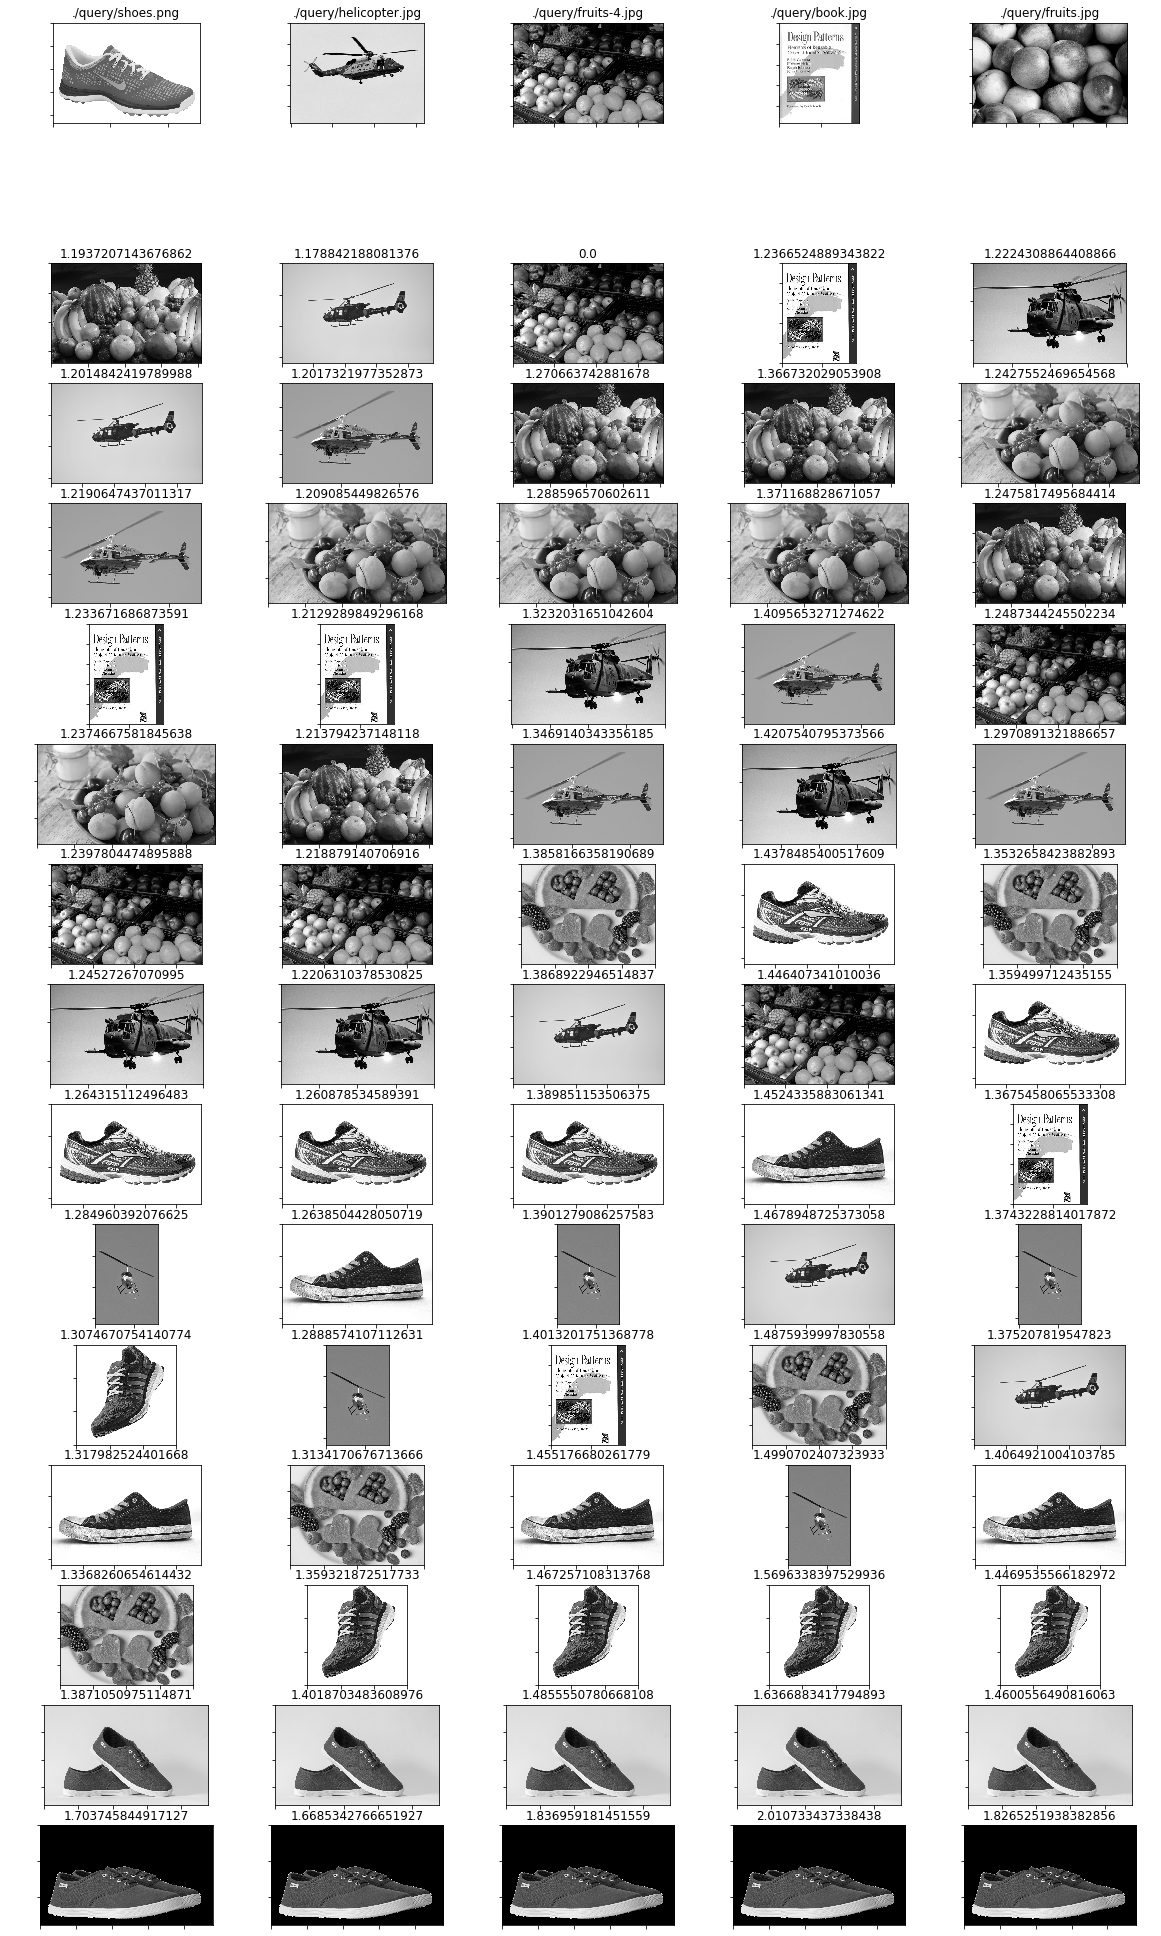

In [100]:

fig, axarr = plt.subplots(nrows = 2 + len(filenames), ncols = len(query_files), figsize=(20,35))

for idx_file, query_file in enumerate(query_files): 
    query_descriptors = image_descriptors_from_file(query_file, descr_extractor=orb_extractor)
    query_vector = visit_tree(root, descriptors=query_descriptors, dissimilarity=orb_dissimilarity, with_weight=True)

    scores = {}
    for idx, db_item_vector in enumerate(db_visit_matrix):
        scores[score_calculation(query_vector, db_item_vector)] = filenames[idx]

    #plt.figure(idx)
    #plt.subplot(14, 5, idx_file+1)
    #plt.imshow(read_image(query_file))
    #for db_idx, db_filename in enumerate(filenames):
    #    plt.subplot(14, 5, (idx_file+1)*(db_idx+1))
    #    plt.imshow(read_image(db_filename))
    
    axarr[0, idx_file].imshow(read_image(query_file), cmap='gray')
    axarr[0, idx_file].set_title(query_file)
    axarr[0, idx_file].set_xticklabels([])
    axarr[0, idx_file].set_yticklabels([])
    
    axarr[1, idx_file].axis('off')
    
    idx_db = 2
    for score in sorted(scores.keys()):
        db_filename = scores[score]
        axarr[idx_db, idx_file].imshow(read_image(db_filename), cmap='gray')
        axarr[idx_db, idx_file].set_title(score)
        axarr[idx_db, idx_file].set_xticklabels([])
        axarr[idx_db, idx_file].set_yticklabels([])
        idx_db += 1

plt.show()

### Test 1 Conclusions
Vocabulary tree seems to have work as expected.
* when searched with database image (fruits-4) the nearest result had distance 0 as expected since there is an identical image in the database
* when searched with very similar image (book) the expected answer (book-1) was returned
* when searched with semantically similar images there were good results for (fruits) and (helicopter) but not so good for (shoes).

Perhaps using a ground truth by actually comparing each descriptor from database with query could help elucidate if this results with similar images are happening due a limitation in the image descriptor itself.